## __Social Network Analysis Colloquium Assignment__
## By Yoseph Zuskin, 1000841958, Feb 19th, 2020

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.collections import PatchCollection
from matplotlib import style
style.use('ggplot')

#### In this Notebook are several functions that demonstrate the famous PageRank algorithm once used by Google. A series of custom functions will be defined to perform the steps needed to process a directed network into the transition matrix and initial vector used in the algorithm. An additional custom function is defined to visualize the network to help demonstrate the directional adjacencies of network nodes.

In [2]:
# custom function to generate a toy network based on a given edgelist
def create_toy_network(edgelist):
    """
    Create Toy Network
    custom function, given in the assignment, slighly modified to accept any edgelist
    and to handle common errors which could arise from invalid edgelist input
    
    Parameters:
    edgelist (list of tuples): list of all edges in the toy network
    
    Returns:
    G (DiGraph): networkx directed graph class object based on toy edgelist
    """
    G=nx.DiGraph()
    if len(edgelist[0])==2:
        try:
            G.add_edges_from(edgelist)
            return G
        except ValueError as error:
            print(error)
            print('please ensure all elements in the edgelist have 2 elements in all or 3 elements in all')
    elif len(edgelist[0])==3:
        try:
            G.add_weighted_edges_from(edgelist)
            return G
        except ValueError as error:
            print(error)
            print('please ensure all elements in the edgelist have 2 elements in all or 3 elements in all')
    else:
        raise ValueError('all elements in the input edgelist must all contain either 2 or 3 elements')

In [3]:
# custom function to visualize the toy network
def visualize_toy_network(G,color_map=plt.cm.CMRmap,node_color='grey',
                          arrow_size=10,label_color='red',label_size=18):
    """
    Visualize Toy Network, adapted from online sources specified below
    visualize the toy network using the steps outlined in the following networkx documentation link:
    https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_directed.html
    Author: Rodrigo Dorantes-Gilardi (rodgdor@gmail.com)
    added labels to the visualization using the steps outlined in the following documentation link:
    https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_labels_and_colors.html
    Author: Aric Hagberg (hagberg@lanl.gov)
    """
    pos = nx.layout.spring_layout(G)

    node_sizes = [3 + 10 * i for i in range(len(G))]
    M = G.number_of_edges()
    edge_colors = range(2, M + 2)
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    
    node_labels={}
    for node in list(G.nodes):
        node_labels[node] = r'$'+str(node)+r'$'

    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_color)
    labels = nx.draw_networkx_labels(G, pos, labels=node_labels,
                                     font_size=label_size, font_color=label_color)
    edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                                   arrowsize=arrow_size, edge_color=edge_colors,
                                   edge_cmap=color_map, width=2)
    
    # set alpha value for each edge
    for i in range(M):
        edges[i].set_alpha(edge_alphas[i])

    pc = PatchCollection(edges, cmap=color_map)
    pc.set_array(edge_colors)
    plt.colorbar(pc)

    ax = plt.gca()
    ax.set_axis_off()
    plt.show()

In [4]:
def sequence(G):
    """
    Sequence
    custom function to return the ordinal sequence dictionary for the input netowrkx graph
    
    Parameters:
    G (netowrkx.DiGraph): directed network graph object from the networkx package
    
    Returns:
    nodes_dict (dict): dictionary of node keys paired with ordinal index values
    nodes_list (list): list of index values representing ordinal sequence of nodes
    """
    nodes_dict = dict() # initiate empty dictionary to populate sequence into
    nodes_list = sorted(G.nodes) # define list of nodes in the input networkx DiGraph
    output_list = list() # initate empty list to store the new ordinal sequence
    for i in range(len(nodes_list)): # iterate over all nodes in the input networkx DiGraph
        nodes_dict[nodes_list[i]] = i # append the updates ordinal sequence to the dictionary
    for node in list(G.nodes): # iterate over all nodes in the input networkx DiGraph
        output_list.append(nodes_dict[node]) # append new index to output list
    return nodes_dict, output_list # return both sequence dictionary and sequence list

In [5]:
def create_transition_matrix(G,d=0.85,has_weight=False):
    """
    Create Transition Matrix
    custom function that returns a transition matrix of the toy network, with the
    rows following ordinal sequence based on numbers rather than edgelist ordering
    
    Parameters:
    G (networkx.DiGraph): directed network graph object from the networkx package
    d (float): dampening factor between 0.0 and 1.0 range
    has_weight (binary): toggle as true for weighted G inputs
    
    Returns:
    transition_matrix (numpy.matrix): transition matrix arranged by ordinal node sequence
    """
    
    # first retrieve nodes dictionary and ordinal sequence list
    nodes_dict, nodes_order = sequence(G)
    inv_nodes_dict = {v: k for k, v in nodes_dict.items()}
    order = G.order() # define networkx DiGraph order
    nodes_list = sorted(G.nodes) # define list of nodes
    adjacency = dict(G.adjacency()) # define adjacencies
    transition_matrix = list() # initiate output list
    for node in nodes_list: # iterate over all nodes
        node_vector = list() # initiate vector list
        # define the edge connections of each node by ordinal sequnce index
        neighbor_indices = [nodes_dict[n] for n in G.neighbors(node)]
        edge_count = len(neighbor_indices) # determine how many edges exist per node
        for i in range(order): # iterate over the length of vector list
            if i in neighbor_indices: # check if an edge exists toward a neighbor node
                if has_weight: # scale edge probability by weight if weighted
                    sum_weights = sum([w['weight'] for w in list(adjacency[node].values())])
                    node_vector.append(adjacency[node][inv_nodes_dict[i]]['weight']/sum_weights)
                else: # else calculate edge probability without any weights
                    node_vector.append(1/edge_count) # append edge probability here
            elif edge_count == 0: # if no edges exist
                node_vector.append(1/order) # append probability over order
            else: # else append a zero as no edge exists towards this node
                node_vector.append(0)
        transition_matrix.append(node_vector) # append vector to output list
    # transform the output list in a transition (numpy) matrix
    transition_matrix = np.matrix(transition_matrix).T
    # apply dampening factor to the transition matrix
    transition_matrix = d*transition_matrix+(1-d)*np.repeat(1/order,order)
    return transition_matrix

In [6]:
def create_initial_vector(G):
    """
    Create Initial Vector
    custom function to generate the initial vector in the pagerank algorithm
    
    Parameters:
    G (networkx.DiGraph):  directed network graph object from the networkx package
    
    Returns:
    initial_vector (numpy.matrix): initial vector in the pagerank algorithm
    """
    
    initial_vector = np.empty(G.order())
    initial_vector.fill(1/G.order())
    initial_vector=np.matrix(np.array([initial_vector]).T)
    
    return initial_vector

In [7]:
def pagerank(G,d=0.85,has_weight=False,max_iter=1000,verbose=False):
    """
    Pagerank
    custom function to replicate the pagerank algorithm which google initially used
    
    Parameters:
    G (networkx.DiGraph): directed network graph object from the networkx package
    d (float): dampening factor between 0.0 and 1.0 range
    has_weight (binary): toggle as true for weighted G inputs
    max_iter (integer): maximum number of iterations to cap the loop for large sparse networks
    verbose (binary): optional setting to print the number of iterations to convergence
    
    Returns:
    page_rank_dict (dictionary): pagerank results, sorted by nodes' ordinal sequence
    """

    # initiate output dictionary instance
    page_rank_dict = dict()
    
    # define ordinal sequence of nodes
    nodes_dict, nodes_order = sequence(G)

    # transistion matrix
    transition_matrix = create_transition_matrix(G, d, has_weight)
    
    # initial vector
    initial_vector = create_initial_vector(G)

    # iterate until convergence or max_iter
    new_vector = transition_matrix * initial_vector
    for i in range(1,max_iter):
        # update vector to pageranks for current iteration
        updated_vector = transition_matrix * new_vector
        # check if current iteration is unchanged from previous
        if all(updated_vector == new_vector):
            if verbose: # check if option to print when convergence occurs is toggled
                print('Convergence achieved on iternation #{}'.format(i-1))
            break # stop if convergence is reached
        else: # otherwise update the pagerank vector
            new_vector = updated_vector

    # populate output dictionary
    for node,rank in zip(list(nodes_dict.keys()),new_vector.tolist()):
        page_rank_dict[node] = rank[0]
        
    return page_rank_dict

#### Now let's test out the custom pagerank function and compare it to the one in the networkx library

In [8]:
# define the toy edgelist given in the assignment
toy_edgelist=[('9','7'),
              ('8','7'),
              ('8','6'),
              ('8','5'),
              ('7','6'),
              ('7','5'),
              ('6','5'),
              ('6','4'),
              ('5','4'),
              ('4','3'),
              ('4','1'),
              ('8','7'),
              ('3','2'),
              ('3','1'),
              ('2','1')]

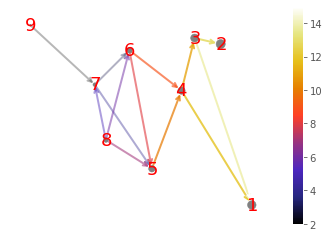

In [9]:
# visualize the toy network given in the assignment
visualize_toy_network(create_toy_network(toy_edgelist))

In [10]:
# test the custom pagerank function
pagerank(create_toy_network(toy_edgelist),d=0.85,has_weight=False,max_iter=500,verbose=False)

{'1': 0.2413094655318948,
 '2': 0.0888916753462409,
 '3': 0.11631687121936145,
 '4': 0.18084674386199803,
 '5': 0.12313544859720683,
 '6': 0.0864108411208469,
 '7': 0.08417494416642621,
 '8': 0.03945700507801229,
 '9': 0.03945700507801229}

In [11]:
# compare the custom output to the networkx pagerank function's results
nx.pagerank_numpy(create_toy_network(toy_edgelist),alpha=0.85)

{'9': 0.03945700507801233,
 '7': 0.08417494416642629,
 '8': 0.039457005078012336,
 '6': 0.08641084112084689,
 '5': 0.12313544859720699,
 '4': 0.18084674386199803,
 '3': 0.11631687121936148,
 '1': 0.24130946553189464,
 '2': 0.08889167534624104}

#### The custom PageRank algorithm function demonstrated in this notebook is successfully returning nearly the same values as the netowrkx equivalent, with the additional advantages of showing the output dictionary in the sorted sequence of the nodes, rather than order by which they appear on the edgelist, and having the option to print the number of iterations required to achieve converges